# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug bokeh

In [16]:
import os
import sagemaker
import boto3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch



In [8]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget --no-check-certificate https://udacity-ml-aws.s3.us-east-2.amazonaws.com/udacity-ml-aws/dogImages.zip
#!aws s3 cp s3://udacity-ml-aws/dogImages.zip $HOME/dogImages.zip

--2024-07-31 21:32:26--  https://udacity-ml-aws.s3.us-east-2.amazonaws.com/udacity-ml-aws/dogImages.zip
Resolving udacity-ml-aws.s3.us-east-2.amazonaws.com (udacity-ml-aws.s3.us-east-2.amazonaws.com)... 52.219.177.138, 3.5.129.113, 3.5.132.185, ...
Connecting to udacity-ml-aws.s3.us-east-2.amazonaws.com (udacity-ml-aws.s3.us-east-2.amazonaws.com)|52.219.177.138|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 403 Forbidden
2024-07-31 21:32:26 ERROR 403: Forbidden.



In [10]:
#!unzip dogImages.zip
!unzip $HOME/dogImages.zip -d $HOME

Archive:  /home/sagemaker-user/dogImages.zip
   creating: /home/sagemaker-user/dogImages/
   creating: /home/sagemaker-user/dogImages/test/
   creating: /home/sagemaker-user/dogImages/train/
   creating: /home/sagemaker-user/dogImages/valid/
   creating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: /home/sagemaker-user/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: /home/sagemaker-user/dogIm

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Answer: I'm using the dog breed classification dataset. 
There are 133 dog breeds in the dataset. The dataset is split into 3 folders, train, test, valid. Each folder contains 133 subfolders. Each subfolder contains images of a particular dog breed.
The structure of the dataset 
```bash
.
├── train
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_00001.jpg
│      ├── Affenpinscher_00002.jpg
│      ├── ....
├── test
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_000036.jpg
│      ├── ...
├── valid
│   ├── 001.Affenpinscher
│      ├── Affenpinscher_000038.jpg
│      ├── ...
```
Makes it so that the classification of each image is done by the name of the folder.

Each image is between 30kb and 100kb in jpg format. Their dimensions differ in both width and height.

Here are examples of two images:


In [67]:
# get home directory

home = os.path.expanduser("~")

data_dir =  os.path.join(home, 'dogImages')
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
bucket_name = 'udacity-ml-aws'
s3_dataset_path = f's3://{bucket_name}/dogImages'



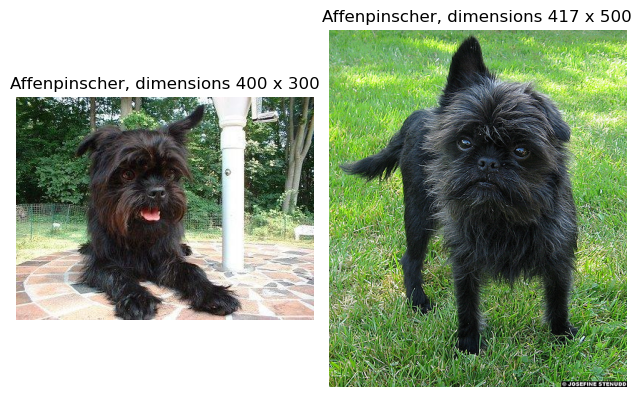

In [68]:
# open 
first_path = os.path.join(train_dir, '001.Affenpinscher', 'Affenpinscher_00001.jpg')
second_path = os.path.join(train_dir, '001.Affenpinscher', 'Affenpinscher_00033.jpg')
image1 = mpimg.imread(first_path)
image2 = mpimg.imread(second_path)

height1, width1, channels1 = image1.shape
height2, width2, channels2 = image2.shape

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2)

# Display the first image
axs[0].imshow(image1)
axs[0].set_title(f'Affenpinscher, dimensions {width1} x {height1}')

axs[0].axis('off')

# Display the second image
axs[1].imshow(image2)
axs[1].set_title(f'Affenpinscher, dimensions {width2} x {height2}')
axs[1].axis('off')


# Adjust layout
plt.tight_layout()
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile, Rule, ProfilerRule, rule_configs
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

# Declare your HP ranges, metrics etc.
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(1e-5, 1e-3, scaling_type="Logarithmic"),
    'batch_size': CategoricalParameter([64, 128]),
    'dropout_rate': ContinuousParameter(0.2, 0.5, scaling_type="Linear"),
    'optimizer': CategoricalParameter(['adam', 'rmsprop']),
    'fc_layer_size': CategoricalParameter([256, 512]),
}

# Create estimators for your HPs
# Your estimator here
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g5.2xlarge",
    #instance_type="ml.m5.xlarge",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    entry_point="hpo.py",  
    rules=rules,
    debugger_hook_config=hook_config,
    hyperparameters={
        'epochs': 4,  # We set this as fixed, but you can make it tunable if you prefer
        'model_dir': '/opt/ml/model',
        's3_data_path': s3_dataset_path
    }
)
# Your HP tuner here
objective_metric_name = 'test:accuracy'
objective_type = 'Maximize'
metric_definitions = [
    {'Name': 'test:accuracy', 'Regex': 'Test set: .*Accuracy: [0-9]+/[0-9]+ \\(([0-9\\.]+)%\\)'}
]

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4,
    objective_type=objective_type
)



Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Configure the data channels

In [5]:
data_channels = {
    'train': f'{s3_dataset_path}/train',
    'validation': f'{s3_dataset_path}/valid',
    'test': f'{s3_dataset_path}/test',
}

## Fit the tuner

In [9]:
tuner.fit(data_channels, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................

### The notebook crashed, so I'm attaching the tuner.

In [5]:
from sagemaker import HyperparameterTuningJobAnalytics
tuning_job_name = 'pytorch-training-240801-1924'
sagemaker_session = sagemaker.Session()
tuner = sagemaker.tuner.HyperparameterTuner.attach(tuning_job_name, sagemaker_session=sagemaker_session)

In [6]:
tuner.best_training_job()

'pytorch-training-240801-1924-008-3239818c'

## Get the best estimator and hypererparameters

In [7]:
import pandas as pd
tuning_analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

In [9]:
summary_df = tuning_analytics.dataframe()
summary_df['dropout_rate'] = summary_df['dropout_rate'].round(3)
summary_df['FinalObjectiveValue'] = summary_df['FinalObjectiveValue'].round(3)

# Display the first few rows of the DataFrame to understand its structure
summary_df

,batch_size,dropout_rate,fc_layer_size,learning_rate,optimizer,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""128""",0.500,"""512""",0.001000,"""rmsprop""",pytorch-training-240801-1924-008-3239818c,Completed,77.99,2024-08-01 19:37:05+00:00,2024-08-01 19:44:45+00:00,460.0
1,"""128""",0.500,"""256""",0.001000,"""rmsprop""",pytorch-training-240801-1924-007-42fa60cf,Completed,63.28,2024-08-01 19:37:03+00:00,2024-08-01 19:44:46+00:00,463.0
2,"""128""",0.473,"""512""",0.000119,"""adam""",pytorch-training-240801-1924-006-a76a076a,Completed,71.41,2024-08-01 19:37:03+00:00,2024-08-01 19:44:44+00:00,461.0
3,"""64""",0.492,"""256""",0.000840,"""rmsprop""",pytorch-training-240801-1924-005-cee15837,Completed,76.32,2024-08-01 19:37:00+00:00,2024-08-01 19:44:40+00:00,460.0
4,"""128""",0.495,"""256""",0.000510,"""rmsprop""",pytorch-training-240801-1924-004-a572276c,Completed,73.56,2024-08-01 19:25:04+00:00,2024-08-01 19:36:02+00:00,658.0
5,"""128""",0.463,"""256""",0.000020,"""adam""",pytorch-training-240801-1924-003-950e7a6c,Completed,22.61,2024-08-01 19:24:52+00:00,2024-08-01 19:36:04+00:00,672.0
6,"""128""",0.420,"""256""",0.000330,"""rmsprop""",pytorch-training-240801-1924-002-d813dd15,Completed,71.77,2024-08-01 19:24:50+00:00,2024-08-01 19:35:58+00:00,668.0
7,"""64""",0.353,"""256""",0.000079,"""rmsprop""",pytorch-training-240801-1924-001-cd94c0a3,Completed,67.11,2024-08-01 19:24:53+00:00,2024-08-01 19:35:56+00:00,663.0


In [22]:
# save the datafame to a csv file
df.to_csv('./assets/hpo_results.csv', index=False)

# Convert summary_df to a markdown table and save it to a file
with open('./assets/summary_df.md', 'w') as f:
    summary_md = summary_df.drop(columns=['TrainingStartTime', 'TrainingEndTime']).to_markdown(index=False)
    f.write(summary_md)

In [28]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2024-08-01 19:44:47 Starting - Found matching resource for reuse
2024-08-01 19:44:47 Downloading - Downloading the training image
2024-08-01 19:44:47 Training - Training image download completed. Training in progress.
2024-08-01 19:44:47 Uploading - Uploading generated training model
2024-08-01 19:44:47 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"test:accuracy"',
 'batch_size': '"128"',
 'dropout_rate': '0.5',
 'epochs': '4',
 'fc_layer_size': '"512"',
 'learning_rate': '0.001',
 'model_dir': '"/opt/ml/model"',
 'optimizer': '"rmsprop"',
 's3_data_path': '"s3://udacity-ml-aws/dogImages"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-08-01-19-24-07-468"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-19-24-07-468/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

### Set up debuebugging and profiling rules and hooks

In [29]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [30]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [31]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"test:accuracy"',
 'batch_size': '"128"',
 'dropout_rate': '0.5',
 'epochs': '4',
 'fc_layer_size': '"512"',
 'learning_rate': '0.001',
 'model_dir': '"/opt/ml/model"',
 'optimizer': '"rmsprop"',
 's3_data_path': '"s3://udacity-ml-aws/dogImages"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-08-01-19-24-07-468"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-19-24-07-468/source/sourcedir.tar.gz"'}

In [34]:
training_hyperparameters = {
    'epochs': 10,
    'batch_size': 128,
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'optimizer': 'rmsprop',
    'fc_layer_size': 512,
    's3_data_path': s3_dataset_path
}

estimator = PyTorch(
    entry_point='train_model.py',
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.g5.2xlarge',
    framework_version='1.8',
    py_version='py36',              # Python version to use
    hyperparameters=training_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [35]:
# Now, let's fit our estimator
os.environ['SM_MODEL_DIR']="s3://"+ bucket_name+ "/model_train/" # where model will be stored
estimator.fit(data_channels, wait=True)




INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-08-01-23-18-00-161


2024-08-01 23:18:00 Starting - Starting the training job...
2024-08-01 23:18:30 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-08-01 23:18:55 Downloading - Downloading input data......
2024-08-01 23:20:01 Downloading - Downloading the training image..................
2024-08-01 23:22:58 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-01 23:23:11,228 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-01 23:23:11,255 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-01 23:23:11,257 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-01 23:23:11,523 sagemaker-training-toolkit INF

In [36]:
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()

In [37]:
# Get the current job name from the estimator
current_job_name = estimator.latest_training_job.name if estimator.latest_training_job else None

# Print the current job name, if available
if current_job_name:
    print(f"Current job name: {current_job_name}")
else:
    print("No job has been started yet.")

Current job name: pytorch-training-2024-08-01-23-18-00-161


In [8]:
# if the notebook crashes in the middle
debug_artifacts_path = ' s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/debug-output'
current_job_name = 'pytorch-training-2024-08-01-23-18-00-161'
sagemaker_session = sagemaker.Session()
estimator = sagemaker.estimator.Estimator.attach(current_job_name, sagemaker_session=sagemaker_session)



2024-08-01 23:41:02 Starting - Preparing the instances for training
2024-08-01 23:41:02 Downloading - Downloading the training image
2024-08-01 23:41:02 Training - Training image download completed. Training in progress.
2024-08-01 23:41:02 Uploading - Uploading generated training model
2024-08-01 23:41:02 Completed - Training job completed


### Plot a debugging output

In [9]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

# Create a trial object with the path to the debugger output
trial = create_trial(debug_artifacts_path)

[2024-08-02 20:26:47.067 default:21207 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


[2024-08-02 20:26:47.642 default:21207 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/debug-output


In [10]:
training_job = TrainingJob(current_job_name)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-2-348722577408/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/profiler-output


Profiler data from system is available


### Get the training and val / test losses and plot them

In [11]:
loss_names = trial.tensor_names(collection='losses')
print(loss_names)
print('CrossEntropyLoss_output_0 train length:', len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print('CrossEntropyLoss_output_0 eval length:', len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
print('CrossEntropyLoss_output_1 eval length:', len(trial.tensor("CrossEntropyLoss_output_1").steps(mode=ModeKeys.EVAL)))


[2024-08-02 20:26:59.233 default:21207 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.


[2024-08-02 20:27:00.251 default:21207 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'CrossEntropyLoss_output_1']
CrossEntropyLoss_output_0 train length: 530
CrossEntropyLoss_output_0 eval length: 77
CrossEntropyLoss_output_1 eval length: 7


#### The means that CrossEntropyLoss_output_0 Train refers to training, CrossEntropyLoss_output_0 EVAL refers to validation and CrossEntropyLoss_output_1 EVAL refers to test

Let's plot the train and validation losses

In [52]:
#Get the loss data
train_steps = trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)
train_losses = [trial.tensor("CrossEntropyLoss_output_0").value(step, mode=ModeKeys.TRAIN) for step in train_steps]

val_steps = trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)
val_losses = [trial.tensor("CrossEntropyLoss_output_0").value(step, mode=ModeKeys.EVAL) for step in val_steps]



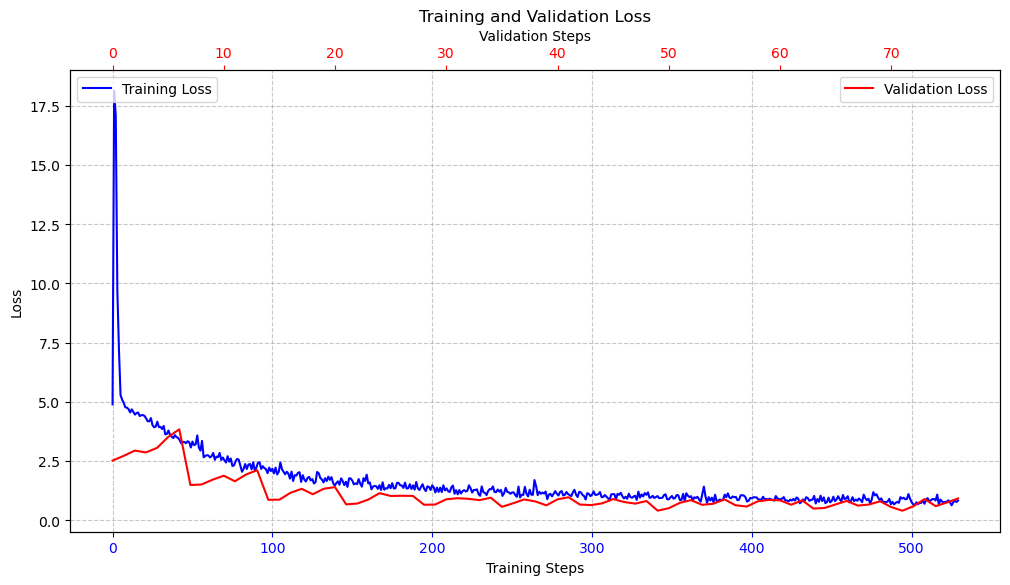

In [54]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training loss on the primary x-axis
ax1.plot(train_steps, train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='x', colors='blue')
ax1.legend(loc='upper left')

# Create a second x-axis for validation loss
ax2 = ax1.twiny()  # Create a second x-axis sharing the same y-axis
ax2.plot(val_steps, val_losses, label='Validation Loss', color='red')
ax2.set_xlabel('Validation Steps')
ax2.tick_params(axis='x', colors='red')
ax2.legend(loc='upper right')

# Customize the plot
ax1.set_title('Training and Validation Loss')
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Print the latest training job’s rule summary in real time


In [60]:
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=current_job_name)

for name, description in description.items():
    if 'tatus' in name:
        print(name)
        print(description)
        print()

TrainingJobStatus
Completed

SecondaryStatus
Completed

SecondaryStatusTransitions
[{'Status': 'Starting', 'StartTime': datetime.datetime(2024, 8, 1, 23, 18, 0, 718000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 8, 1, 23, 18, 50, 317000, tzinfo=tzlocal()), 'StatusMessage': 'Preparing the instances for training'}, {'Status': 'Downloading', 'StartTime': datetime.datetime(2024, 8, 1, 23, 18, 50, 317000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 8, 1, 23, 22, 58, 132000, tzinfo=tzlocal()), 'StatusMessage': 'Downloading the training image'}, {'Status': 'Training', 'StartTime': datetime.datetime(2024, 8, 1, 23, 22, 58, 132000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 8, 1, 23, 39, 42, 480000, tzinfo=tzlocal()), 'StatusMessage': 'Training image download completed. Training in progress.'}, {'Status': 'Uploading', 'StartTime': datetime.datetime(2024, 8, 1, 23, 39, 42, 480000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 8, 1, 23, 40, 0, 50000, tzinfo

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

_Answer: Not really... I think it looks fine_

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

_Answer: <br>Depends... If the there were a general bug problem, then TrainingJobStatus wouldn't have been completed. <br>
DebugRuleEvaluationStatuses would show specific problems that I set to look for when configuring the rules._

## Display profiler output

In [47]:
# get the path

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)

s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/rule-output


In [48]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-1

In [50]:
import IPython

IPython.display.HTML(filename="./ProfilerReport/profiler-output/profiler-report.html")

### This was super helfpul!!! the fact that it told me to increase the batch size can really speed up future training jobs!!

## Model Deploying

In [97]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=IdentitySerializer(content_type='image/jpeg'),
            deserializer=JSONDeserializer()
        )

In [98]:
model_location=estimator.model_data
print("The model location is: ", model_location)

The model location is:  s3://sagemaker-us-east-2-348722577408/pytorch-training-2024-08-01-23-18-00-161/output/model.tar.gz


In [99]:
predictor_model = PyTorchModel(
    model_data=model_location, 
    role=sagemaker.get_execution_role(),
    entry_point="inference.py",
    py_version="py36",
    framework_version="1.8",
    predictor_cls=ImagePredictor
)

In [100]:
predictor = predictor_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

### The Endpoint URL

In [102]:
# find the endpoing
predictor.endpoint_name

'pytorch-inference-2024-08-02-22-38-46-259'

In [103]:
with open(first_path, "rb") as f:
    img_bytes = f.read()

In [104]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [121]:
def predict_and_show(img_path: str, label_number: int, label_name: str, predictor: ImagePredictor) -> None:
    """
    Show image and prediction
    """
    with open(img_path, "rb") as f:
        img_bytes = f.read()
    
    # show image
    image = mpimg.imread(img_path)

    height, width, channels = image.shape

    # not subplots
    fig, axs = plt.subplots(1, 1)

    # Display the image
    axs.imshow(image)
    axs.set_title(f'{label_name}, dimensions {width} x {height}')
    axs.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

    prediction_weights = list(zip(range(133), response[0]))
    print('The most likely answer is: ')
    likely_class_number = max(prediction_weights, key=lambda x: x[1])[0]
    if likely_class_number == label_number:
        print(f'Correct! It is a {label_name}.')
    else:
        print(f'Incorrect!')
        print(likely_class_number)




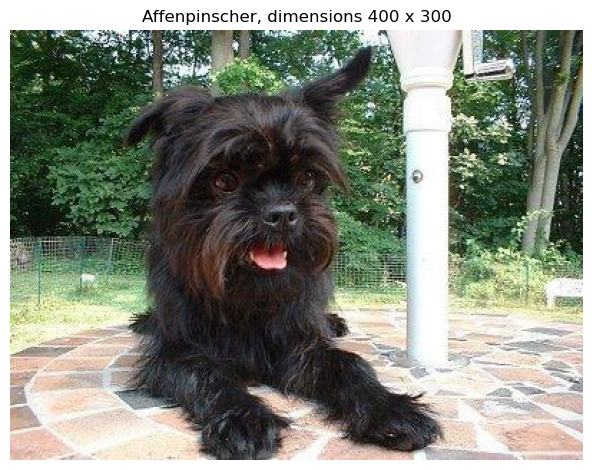

The most likely answer is: 
Correct! It is a Affenpinscher.


In [122]:
predict_and_show(first_path, 0, 'Affenpinscher', predictor)

## Let's try a german shepherd


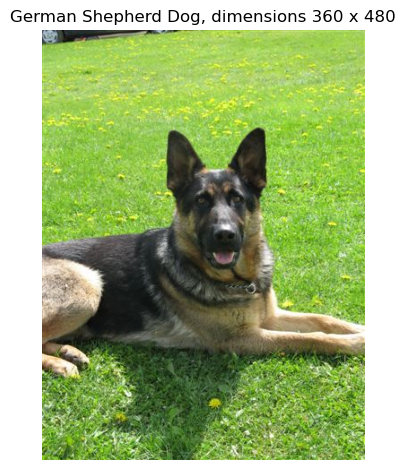

The most likely answer is: 
Correct! It is a German Shepherd Dog.


In [124]:
predict_and_show(os.path.join('./assets', 'German_shepherd_dog_04898.jpg'), 70, 'German Shepherd Dog', predictor)

## Nice!

In [125]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()